In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

def funcion(nombre):
    # Abrir el archivo de texto
    with open(nombre, "r") as f:
        # Saltar las tres primeras líneas
        next(f)
        next(f)
        next(f)
        
        # Leer todas las líneas restantes
        all_data = f.readlines()   
    
    # Procesar cada línea, dividiendo por tabulaciones
    all_data = [line.strip().split('\t') for line in all_data]
    
    # Extraer la primera columna (muestra)
    sample = [int(row[0]) for row in all_data]  # Primera columna

    # Crear una secuencia de números para la muestra (opcional, según tu lógica)
    sample = np.arange(0, len(sample))  # Reemplaza los valores por una secuencia 0, 1, 2, ..., n
    
    # Extraer la sexta columna (amplitud)
    amplitude = [int(row[5]) for row in all_data]  # Sexta columna (índice 5)
    amplitude = np.array(amplitude)
    return sample, amplitude  # Devolver los valores de la muestra y amplitud

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # Frecuencia de Nyquist
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def fourier(s_filtrada):
    T=1/1000
    frequencies = np.fft.fftfreq(len(s_filtrada[:]), T)
    signal_fft = np.fft.fft(s_filtrada[:])
    # Solo tomamos la parte positiva de la transformada
    positive_frequencies = frequencies[:len(frequencies)//2]
    positive_signal_fft = np.abs(signal_fft[:len(signal_fft)//2])
    return positive_frequencies,positive_signal_fft



def grafica(sample, amplitude, filtrada):
    plt.figure(figsize=(12, 6))

    # Gráfico de la señal original
    plt.subplot(1, 2, 1)
    plt.plot(sample / 1000, amplitude)
    plt.title('Señal EEG Original')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud')

    # Gráfico de la señal filtrada
    plt.subplot(1, 2, 2)
    plt.plot(sample / 1000, filtrada)
    plt.title('Señal EEG Filtrada')
    plt.xlabel('Tiempo [s]')
    plt.ylabel('Amplitud Filtrada')

    plt.tight_layout()
    plt.show()

    # Comparar la Transformada de Fourier de la señal original y la filtrada
    frecuencia_original, signalFFT_original = fourier(amplitude)
    frecuencia_filtrada, signalFFT_filtrada = fourier(filtrada)

    plt.figure(figsize=(12, 6))

    # Comparación de las transformadas de Fourier
    plt.subplot(1, 2, 1)
    plt.plot(frecuencia_original, signalFFT_original)
    #plt.plot(frecuencia_filtrada, signalFFT_filtrada, label='Filtrada')
    plt.ylim(min(signalFFT_original),max(signalFFT_filtrada))
    plt.title('Sin filtrar Transformada de Fourier')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Amplitud')
    plt.legend()

     
    plt.subplot(1, 2, 2)
    plt.plot(frecuencia_filtrada,signalFFT_filtrada, label='Filtrada (dB)')
    plt.title('Transformada de Fourier  (Filtrada)')
    plt.xlabel('Frecuencia [Hz]')
    plt.ylabel('Amplitud ')
  
    plt.tight_layout()
    plt.show()

Longitud original de amplitude2: 35094
Longitud original de amplitude1: 28629
Longitud final de amplitude2: 35094
Longitud final de amplitude1: 35094
3648.6029638331356


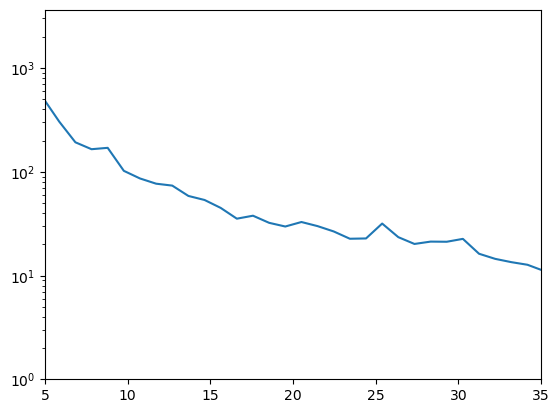

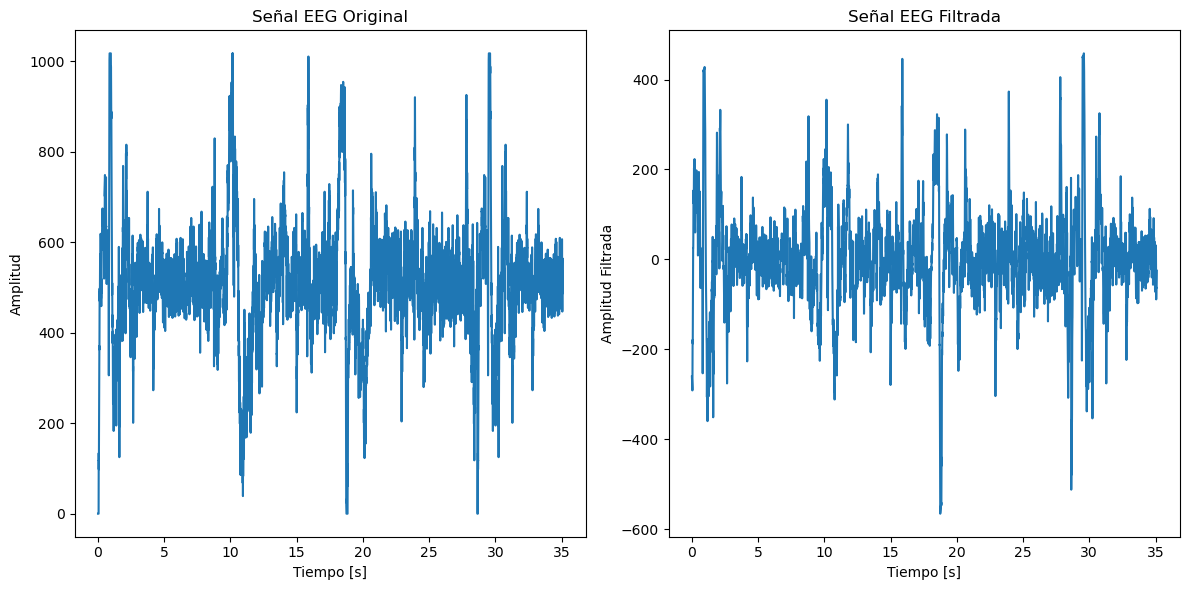

C:\Users\aleja\AppData\Local\Temp\ipykernel_1940\2828331888.py:87: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


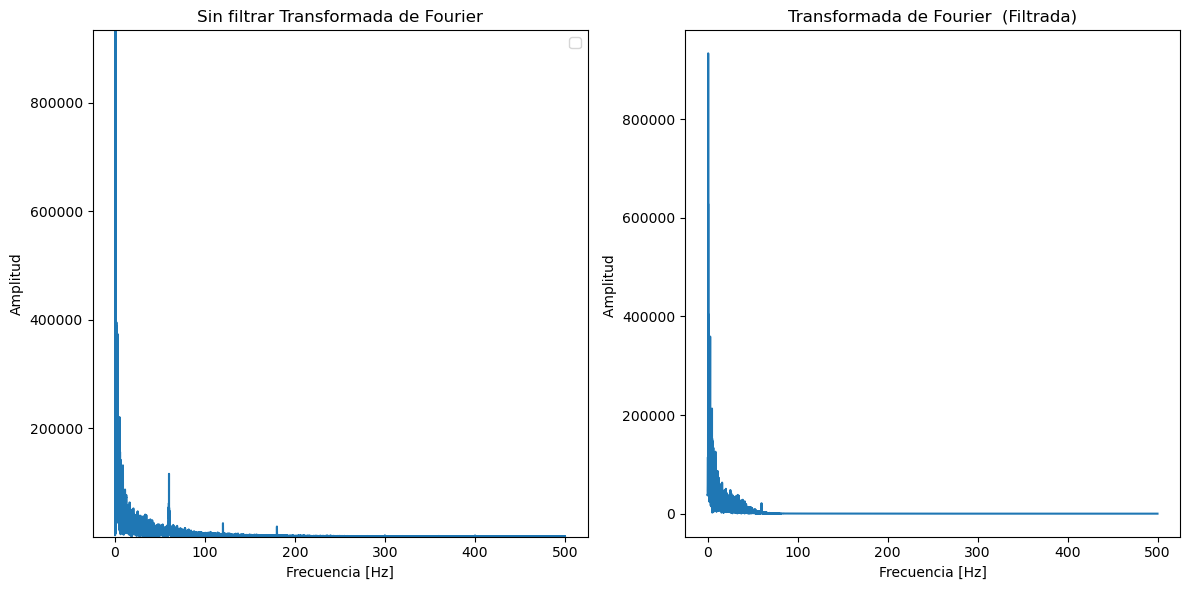

In [5]:
from scipy.signal import welch

# Suponiendo que funcion() carga los datos y devuelve sample y amplitude2
sample, amplitude2 = funcion("30s2.txt")
sample, amplitude1 = funcion("facil_pregunta.txt")

# Imprimimos las longitudes actuales de amplitude1 y amplitude2
print("Longitud original de amplitude2:", len(amplitude2))
print("Longitud original de amplitude1:", len(amplitude1))

# Aseguramos que amplitude1 y amplitude2 tengan la misma longitud
if len(amplitude1) < len(amplitude2):
    repeat_times = len(amplitude2) // len(amplitude1)
    remainder = len(amplitude2) % len(amplitude1)

    amplitude1 = np.tile(amplitude1, repeat_times)
    amplitude1 = np.concatenate((amplitude1, amplitude1[:remainder]))

# Verificamos que ambas señales ahora tienen la misma longitud
print("Longitud final de amplitude2:", len(amplitude2))
print("Longitud final de amplitude1:", len(amplitude1))

#amplitude = amplitude1 - amplitude2 #Le restamos a la onda de tareas faciles los componentes del basal. De esta forma se espera solo tener los datos especificos relacionados a las tareas faciles.
filtrada = butter_bandpass_filter(amplitude1, 0.5, 50, 1000, 4)
sample = np.arange(len(amplitude1))

# Calculamos la densidad espectral de potencia usando el método de Welch
f, Pxx_den = welch(filtrada, 1000, nperseg=1024)

plt.semilogy(f,Pxx_den)
plt.xlim([5,35])
plt.ylim([1,max(Pxx_den)])
max_index = np.argmax(Pxx_den)  # Índice donde se encuentra el máximo
max_value = Pxx_den[max_index]  # Valor máximo de Pxx_den
max_frequency = f[max_index]   
print(max_value)

plt.show()

grafica(sample,amplitude1,filtrada)


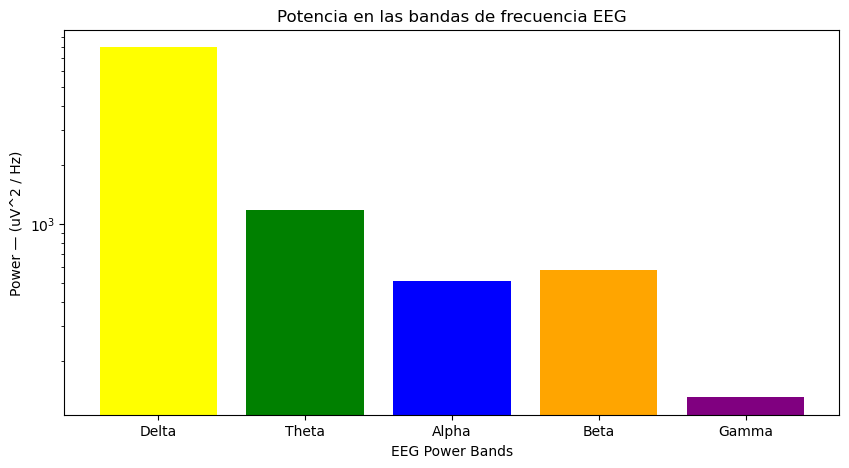

In [6]:
# Definición de las bandas de frecuencia EEG
bandas_eeg = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 32),
    'Gamma': (32, 50)
}

# Calcular la potencia en cada banda EEG
potencias = []
for banda, (low_freq, high_freq) in bandas_eeg.items():
    # Seleccionamos los índices que corresponden a las frecuencias dentro de la banda
    indices_banda = np.where((f >= low_freq) & (f <= high_freq))[0]
    
    # Sumamos la potencia de la densidad espectral dentro de la banda
    potencia_banda = np.sum(Pxx_den[indices_banda])
    potencias.append(potencia_banda)

# Crear el gráfico de barras
plt.figure(figsize=(10, 5))
plt.bar(bandas_eeg.keys(), potencias, color=['yellow', 'green', 'blue', 'orange', 'purple'])

# Ajustar los ejes y etiquetas
plt.yscale('log')  # Escala logarítmica para el eje y, como en el gráfico original
plt.ylabel('Power — (uV^2 / Hz)')
plt.xlabel('EEG Power Bands')
plt.title('Potencia en las bandas de frecuencia EEG')
plt.show()